In [1]:
# load important packages

import os
import matplotlib.pyplot as plt
import astropy
import numpy as np
from astropy.io import fits, ascii
from astropy import units as u
from astropy.visualization import ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from mpdaf.obj import iter_spe
from mpdaf.obj import Cube, WCS, WaveCoord

from tqdm import tqdm

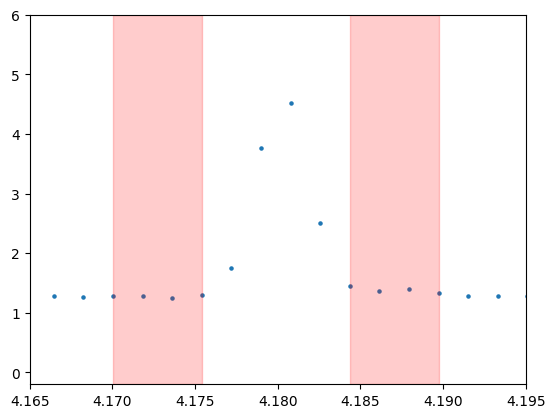

In [2]:
# Read in a 3-D IFU datacube of interest, and header

cube_file = 'jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits'
hdul = fits.open(cube_file)
cube = fits.getdata(cube_file)
header_cube = hdul[1].header

# grab data information and wavelength definitions
nz, ny, nx = cube.shape
crdelt1 = header_cube['CDELT1']
crdelt3 = header_cube['CDELT3']
crval3 = header_cube['CRVAL3']

ster=(crdelt1*(np.pi/180))**2

# define the wavelength grid (microns) from the header
wave = ((crdelt3 * (np.arange(0, nz, 1))) + crval3)

position1 = [(27,44)]
aperture1 = CircularAperture(position1, r=3)
ap_flux1=[]

position2 = [(49,44)]
aperture2 = CircularAperture(position2, r=3)
ap_flux2=[]

position3 = [(28,58)]
aperture3 = CircularAperture(position3, r=3)
ap_flux3=[]

for i in range(len(wave)):
    phot_table1 = aperture_photometry(cube[i,:,:], aperture1)
    ap_flux1.append((phot_table1['aperture_sum'].data[0])*np.pi*(3**2)*ster*1e9)
    
    phot_table2 = aperture_photometry(cube[i,:,:], aperture2)
    ap_flux2.append((phot_table2['aperture_sum'].data[0])*np.pi*(3**2)*ster*1e9)
    
    phot_table3 = aperture_photometry(cube[i,:,:], aperture3)
    ap_flux3.append((phot_table3['aperture_sum'].data[0])*np.pi*(3**2)*ster*1e9)

# make a simple 1d spectrum of the central region
#flux1 = np.median(cube[:,44:46,46:48], axis=(1,2))
#flux1 = np.sum(cube[:,44:46,46:48], axis=(1,2))*9*ster*1e9
flux1 = ap_flux1
flux2 = ap_flux2
flux3 = ap_flux3

# set y-limits for the plot centered around brackett alpha
ymin=np.min(flux1[655:665])-(0.05*np.min(flux1[655:665]))
ymax=np.max(flux1[655:665])+(0.025*np.max(flux1[655:665]))

# set center, resolution and limits for the line and continuum limits

wave_center=4.181
spec_res=crdelt3

wave_emission_limit1 = wave_center-(3*spec_res)
wave_emission_limit2 = wave_center+(2*spec_res)

wavemin = (np.abs(wave-wave_emission_limit1)).argmin() #find the datapoint in the spectrum 
wavemax = (np.abs(wave-wave_emission_limit2)).argmin() #closest to the desired wavelength


contlo_limit1 = wave_emission_limit1-(3*spec_res) #1.5 resolution elements (to avoid neighboring [FeII] line)
contlo_limit2 = wave_emission_limit1
conthi_limit1 = wave_emission_limit2
conthi_limit2 = wave_emission_limit2+(3*spec_res)

contlo_min = (np.abs(wave-contlo_limit1)).argmin()
contlo_max = (np.abs(wave-contlo_limit2)).argmin()
conthi_min = (np.abs(wave-conthi_limit1)).argmin()
conthi_max = (np.abs(wave-conthi_limit2)).argmin()

# plot the 1-D spectrum around Brackett alpha.
plt.figure(0)
plt.scatter(wave, flux1, s=5)
plt.xlim(4.165,4.195)
plt.ylim(-0.2,6)
plt.axvspan(wave[contlo_min], wave[contlo_max], color='red', alpha=0.2)
plt.axvspan(wave[conthi_min], wave[conthi_max], color='red', alpha=0.2)
plt.show()

In [3]:
# estimate continuum using mean of points in selected range

contlo_wave=wave[contlo_min:contlo_max]
conthi_wave=wave[conthi_min:conthi_max]
contlo_flux=flux1[contlo_min:contlo_max]
conthi_flux=flux1[conthi_min:conthi_max]

contwave_array=np.concatenate((contlo_wave, conthi_wave))
contflux_array=np.concatenate((contlo_flux, conthi_flux))

mean_cont=np.sum(contflux_array)/len(contflux_array)


# estimate continuum using 1d polyfit to points in selected range
cont_fit=np.polyfit(contwave_array, contflux_array, 1)
fitval = np.poly1d(cont_fit)
continuum = fitval(wave)    

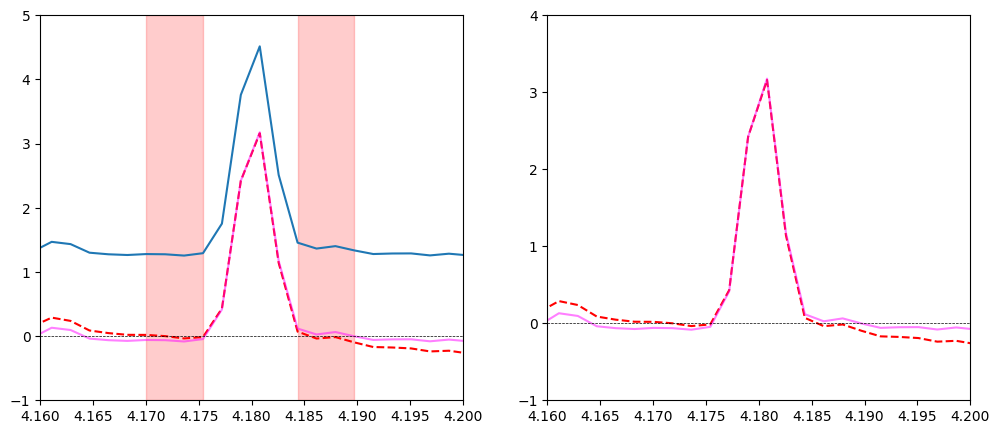

In [4]:
#examine the two continuum-subtracted spectra

cont_sub= flux1-continuum #the polyfit continuum-subtracted flux
meancont_sub=flux1-mean_cont #the mean continuum-subtracted flux

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plt.subplot(121)
plt.plot(wave, flux1)
plt.plot(wave, cont_sub, color='red', linestyle='dashed')
plt.plot(wave, meancont_sub, color='magenta', alpha=0.5)
plt.xlim(4.16,4.2)
plt.ylim(-1,5)
plt.axvspan(wave[contlo_min], wave[contlo_max], color='red', alpha=0.2)
plt.axvspan(wave[conthi_min], wave[conthi_max], color='red', alpha=0.2)
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='dashed')

plt.subplot(122)
plt.plot(wave, cont_sub, color='red', linestyle='dashed')
plt.plot(wave, meancont_sub, color='magenta', alpha=0.5)
plt.xlim(4.16,4.2)
plt.ylim(-1,4)
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='dashed')

#plt.scatter(4.18,4.75, color='magenta', marker='o', s=25)
#plt.scatter(4.18,4.5, color='red', marker='o', s=25)

#plt.text(4.181,4.7, s="= mean continuum", color='magenta', fontsize=14)
#plt.text(4.181,4.45, s="= fit continuum", color='red', fontsize=14)

In [5]:
#create a continuum-subtracted image with MPDAF
obj1 = Cube('jw01802-o003_t001_nirspec_g395m-f290lp_crop1_s3d.fits', mask=True)

cont1 = obj1.clone(data_init=np.empty, var_init=np.zeros)
fitcont = obj1.clone(data_init=np.empty, var_init=np.zeros)
  

for sp, co in tqdm(zip(iter_spe(obj1), iter_spe(cont1))):
    #co[:] = mean_cont
    contlo_sum=np.sum(sp.data[contlo_min:contlo_max])
    conthi_sum=np.sum(sp.data[conthi_min:conthi_max])
    co[:] = (contlo_sum+conthi_sum)/(len(sp.data[contlo_min:contlo_max])+len(sp.data[conthi_min:conthi_max]))
    
for spfit, cofit in tqdm(zip(iter_spe(obj1), iter_spe(fitcont))):
    cont=spfit.data[contlo_min:conthi_max]
    cont_fit=np.polyfit(x=wave[contlo_min:conthi_max], y=cont, deg=1)
    fitval = np.poly1d(cont_fit)
    cofit[contlo_min:conthi_max] = fitval(wave[contlo_min:conthi_max])  

Set OBSGEO-B to    -2.922605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1342653960.157 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-09-15T23:49:00.247' from MJD-AVG.
Set DATE-END to '2022-09-16T01:09:37.494' from MJD-END'. [astropy.wcs.wcs]
8463it [04:11, 33.60it/s]
8463it [04:10, 33.80it/s]


Text(0.5, 1.0, 'Continuum')

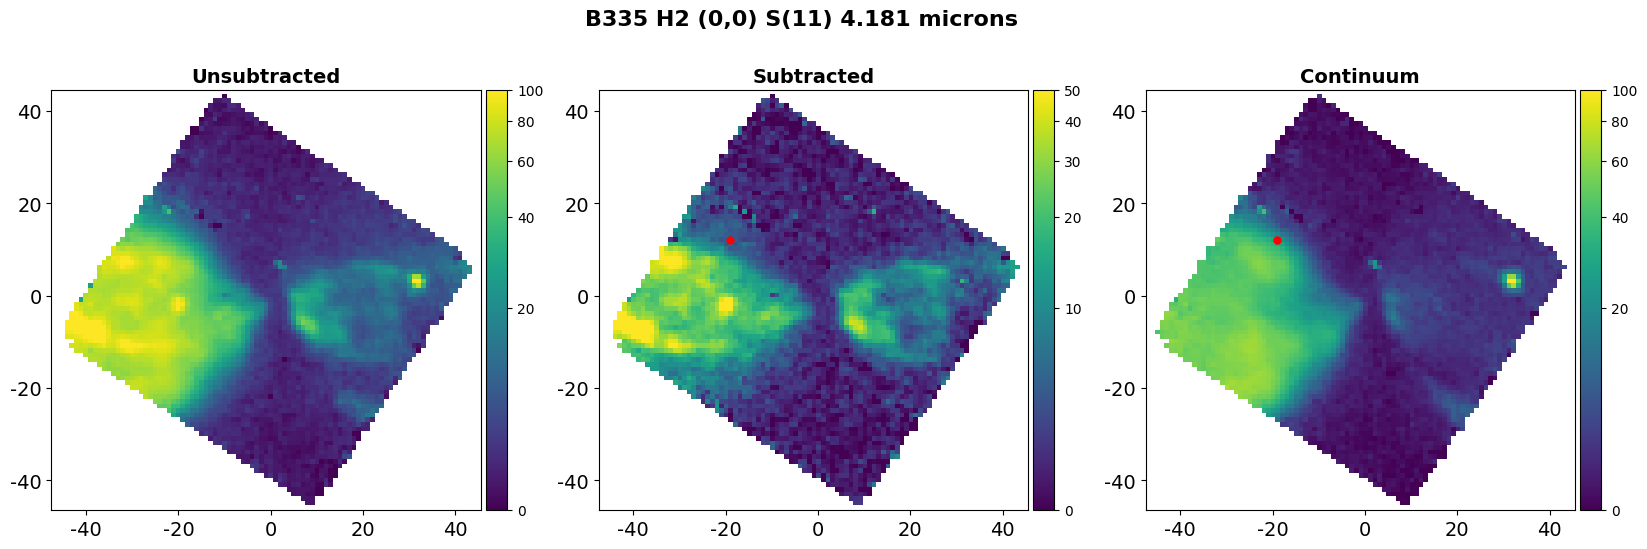

In [6]:
# plot images of the unsubtracted and subtracted images side by side

line1 = obj1 - cont1

#vmin1=-0.15
#vmax1=3.5
vmin1=-0.01
vmax1=100


#vmin2=-0.1
#vmax2=1
vmin2=-0.01
vmax2=50

vmin3=-0.01
vmax3=100


fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,6))
plt.suptitle('B335 H2 (0,0) S(11) 4.181 microns', size=16, fontweight='bold')
xtick=[7,27,47,67,87]
xlabel=['-40','-20','0','20','40']
ytick=[6,26,46,66,86]
ylabel=['-40','-20','0','20','40']

plt.subplot(131)
plt.xticks(ticks=xtick, labels=xlabel, size=14)
plt.yticks(ticks=ytick, labels=ylabel, size=14)
obj1[wavemin:wavemax,:,:].sum(axis=0).plot(scale='asinh', colorbar='v', \
                                           title='Unsubtracted', vmin=vmin1, vmax=vmax1, ax=ax1)

plt.subplot(132)
plt.xticks(ticks=xtick, labels=xlabel, size=14)
plt.yticks(ticks=ytick, labels=ylabel, size=14)
plt.scatter(28,58, color='red', s=25)
line1[wavemin:wavemax,:,:].sum(axis=0).plot(scale='asinh', colorbar='v', \
                                            title='Subtracted', vmin=vmin2, vmax=vmax2, ax=ax2)

plt.subplot(133)
plt.xticks(ticks=xtick, labels=xlabel, size=14)
plt.yticks(ticks=ytick, labels=ylabel, size=14)
plt.scatter(28,58, color='red', s=25)
cont1[wavemin:wavemax,:,:].sum(axis=0).plot(scale='asinh', colorbar='v', \
                                            title='Continuum', vmin=vmin3, vmax=vmax3, ax=ax3)

ax1.set_title('Unsubtracted',size=14, fontweight='bold')
ax2.set_title('Subtracted',size=14, fontweight='bold')
ax3.set_title('Continuum',size=14, fontweight='bold')

#plt.savefig('B335_H2_4_181.pdf', bbox_inches="tight")

In [7]:
 line1[wavemin:wavemax,:,:].sum(axis=0).write('b335_h2_map.fits', savemask='nan')

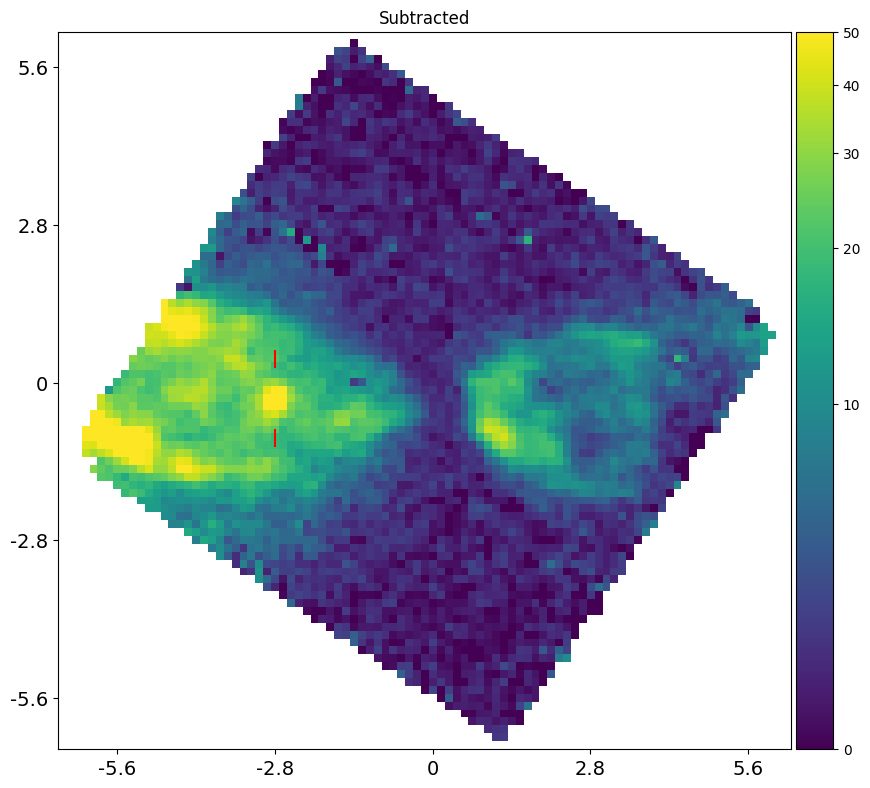

In [8]:
xtick=[7,27,47,67,87]
xlabel=['-5.6','-2.8','0','2.8','5.6']
ytick=[6,26,46,66,86]
ylabel=['-5.6','-2.8','0','2.8','5.6']

fig, (ax1)=plt.subplots(1,1,figsize=(10,10))

plt.subplot(111)
plt.xticks(ticks=xtick, labels=xlabel, size=14)
plt.yticks(ticks=ytick, labels=ylabel, size=14)
plt.scatter(27,49, color='red', s=150, marker='|')
plt.scatter(27,39, color='red', s=150, marker='|')
#plt.plot(dummyx, dummyy, color='red', linewidth=2.5)
line1[wavemin:wavemax,:,:].sum(axis=0).plot(scale='asinh', colorbar='v', \
                                            title='Subtracted', vmin=vmin2, vmax=vmax2, ax=ax1)

plt.savefig('olympia_H2.pdf', bbox_inches="tight")

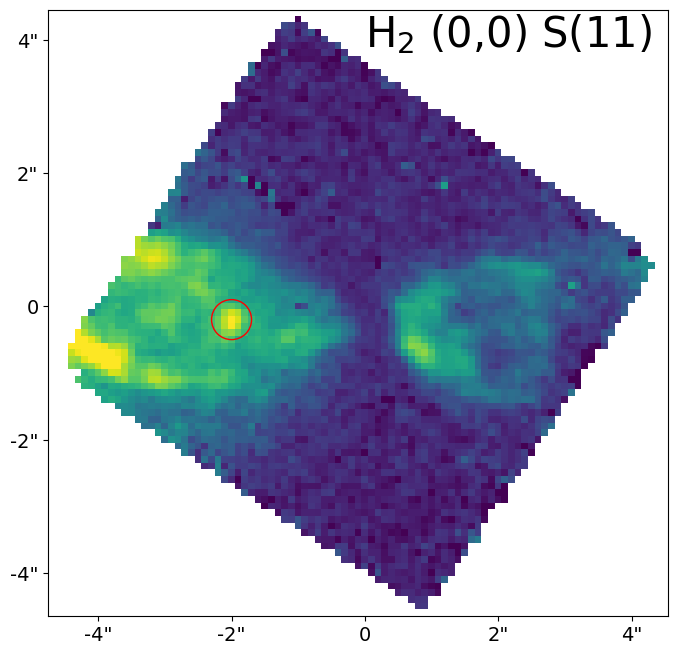

In [10]:
fig, (ax1)=plt.subplots(1,1,figsize=(8,8))
xtick=[7,27,47,67,87]
xlabel=['-4"','-2"','0','2"','4"']
ytick=[6,26,46,66,86]
ylabel=['-4"','-2"','0','2"','4"']

plt.subplot(111)
plt.xticks(ticks=xtick, labels=xlabel, size=14)
plt.yticks(ticks=ytick, labels=ylabel, size=14)
plt.text(90,85, 'H'+r'$_{2}$'+' (0,0) S(11)', color='black', size=30, ha='right')
#plt.scatter(25,25, color='red')
aperture1.plot(color='red')
line1[wavemin:wavemax,:,:].sum(axis=0).plot(scale='asinh', \
                                            vmin=-1, vmax=70, ax=ax1)

#ax2=fig.add_subplot()
#ax2.set_position(pos=[0.15,0.15,0.15,0.15])
#ax2.plot(wave, cont_sub, color='red', linestyle='dashed')
#ax2.plot(wave, meancont_sub, color='magenta', alpha=0.5)
#plt.xlim(4.16,4.2)
#plt.ylim(-1,5)
#ax2.set_xticks([])
#ax2.set_yticks([])
#plt.axhline(y=0, color='black', linewidth=0.5, linestyle='dashed')

plt.savefig('b335_h2_4181.pdf', bbox_inches='tight')

Set OBSGEO-B to    -2.922605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1342653960.157 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -2.922605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1342653960.157 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


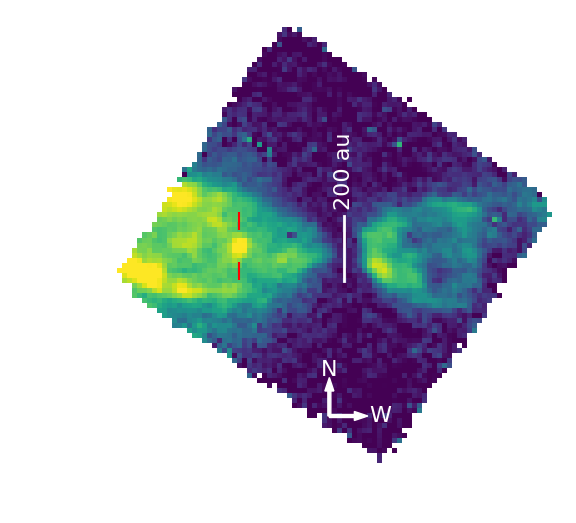

In [11]:
import aplpy

fits_file='b335_h2_map.fits'

dummy1=[48,48]
dummy2=[37,50]

dummy_n1=[20,20]
dummy_n2=[30,35]

dummy_w1=[20,25]
dummy_w2=[30,30]

#Play around with color and scale:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_frame_on(False)
ax.show_axes=False

plt.axis(False)

f1 = aplpy.FITSFigure(fits_file, figure=fig, north=True)
f1.show_colorscale(cmap='viridis', vmin=1, vmid= 5, vmax=50, stretch='arcsinh')
f1.set_nan_color('white')
#f1.add_scalebar((0.5/3600), label='200 au', color='white')

plt.axis(False)
plt.plot(dummy1, dummy2, color='white', linewidth=2)
plt.text(46,52,'200 au', color='white', fontsize=16, rotation=-270)

plt.arrow(45, 10, 0, 5, color='white', width=0.6)
plt.arrow(45, 10, 5, 0, color='white', width=0.6)
plt.text(45,18,'N', color='white', fontsize=16, ha='center')
plt.text(53,10,'W', color='white', fontsize=16, va='center')

plt.scatter(27,49, color='red', s=150, marker='|')
plt.scatter(27,39, color='red', s=150, marker='|')

plt.savefig('b335_h2_posterfig.pdf', bbox_inches='tight')

Set OBSGEO-B to    -2.922605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1342653960.157 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -2.922605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1342653960.157 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/aplpy/core.py:1176: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  s = self.ax.scatter(xw, yw, transform=self.ax.get_transform(coords_frame), **kwargs)
/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/aplpy/core.py:1176: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor 

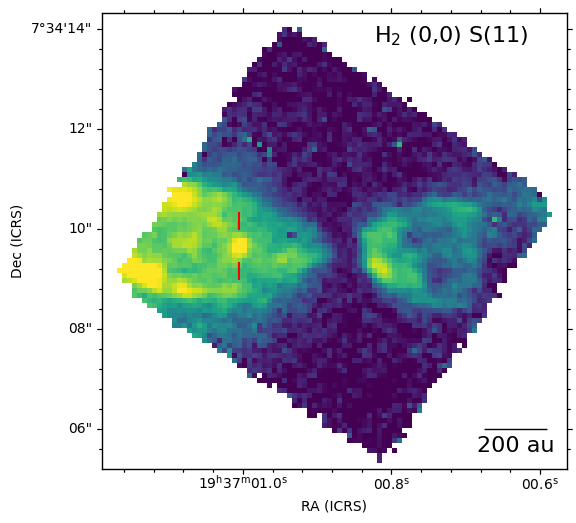

In [4]:
import aplpy

fits_file='b335_h2_map.fits'

fig, ax = plt.subplots(figsize=(6,6))
ax.set_frame_on(False)
ax.show_axes=False

plt.axis(False)

f1 = aplpy.FITSFigure(fits_file, figure=fig, north=True)
f1.show_colorscale(cmap='viridis', vmin=1, vmid= 5, vmax=50, stretch='arcsinh')
f1.set_nan_color('white')
f1.add_scalebar((1.25/3600), label='200 au', color='black', size=16)
f1.add_label(0.75,0.95,'H$_{2}$ (0,0) S(11)', relative=True, size=16)
f1.show_markers(27,49, coords_frame='pixel', facecolor='red', s=150, marker='|')
f1.show_markers(27,39, coords_frame='pixel', facecolor='red', s=150, marker='|')

#aperture1.plot(color='red')
#aperture2.plot(color='blue')
#aperture3.plot(color='orange')

plt.savefig('b335_h2_paperfig.pdf', bbox_inches='tight')
plt.savefig('b335_h2_paperfig.png', bbox_inches='tight')

Set OBSGEO-B to    -2.922605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1342653960.157 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -2.922605 from OBSGEO-[XYZ].
Set OBSGEO-H to 1342653960.157 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))
/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/aplpy/core.py:1176: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  s = self.ax.scatter(xw, yw, transform=self.ax.get_transform(coords_frame), **kwargs)
/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/aplpy/core.py:1176: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor 

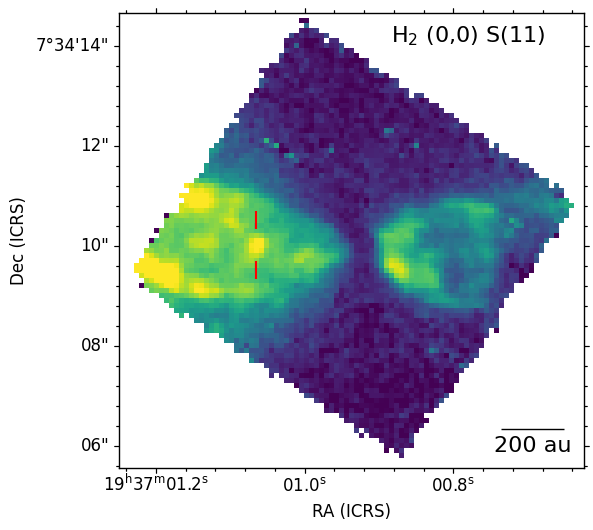

In [3]:
import matplotlib
import aplpy

fitsfile='b335_h2_alt.fits'
fits_hdul = fits.open(fitsfile)
fits_data = fits_hdul[0].data

#fitsdata=np.where(fits_hdul[0].data!=0,fits_hdul[0].data,'nan')
#fits_hdul[0].data[:,:]=fitsdata

mask=np.zeros(cube[1,:,:].shape)
smoothed_data=np.zeros(cube[1,:,:].shape)

for i in range(nx):
    for j in range(ny):
        if str(cube[1,j,i])=='nan':
            mask[j,i]=np.nan

masked_data=mask+np.array(fits_data)

fits.writeto('b335_h2_alt_masked.fits', data=masked_data, header=fits_hdul[0].header, overwrite=True)

masked_file='b335_h2_alt_masked.fits'

fig, ax = plt.subplots(figsize=(6,6))
ax.set_frame_on(False)
ax.show_axes=False

plt.axis(False)

#plt.imshow(data)

f1 = aplpy.FITSFigure(masked_file, figure=fig, north=True)
f1.show_colorscale(cmap='viridis', vmin=1, vmid= 5, vmax=50, stretch='arcsinh')
f1.set_nan_color('white')
f1.add_scalebar((1.25/3600), label='200 au', color='black', size=16)
f1.add_label(0.75,0.95,'H$_{2}$ (0,0) S(11)', relative=True, size=16)
f1.show_markers(27,49, coords_frame='pixel', facecolor='red', s=150, marker='|')
f1.show_markers(27,39, coords_frame='pixel', facecolor='red', s=150, marker='|')
f1.tick_labels.set_font(size=12)
f1.axis_labels.set_font(size=12)

plt.savefig('b335_h2_paperfig.pdf', bbox_inches='tight')
plt.savefig('b335_h2_paperfig.png', bbox_inches='tight')